# 🎓 Final Exam – Developing Notebook (Introduction to ML)

**Duration (suggested):** 120 minutes  
**Environment:** CPU-only; Python 3.8+; `numpy`, `pandas`, `matplotlib`, `scikit-learn`

## Instructions
- Sections build toward an end-to-end workflow.
- Respect provided function names / signatures for the quick checks.
- Use `RANDOM_STATE` for reproducibility.
- Include short written reflections in Markdown where asked.

## 📦 Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

RANDOM_STATE = 123
np.random.seed(RANDOM_STATE)

## A. Conceptual (Short Answers)

### A1. Classical ML vs Deep Learning
**Q:** In 4–6 sentences, compare classical ML and deep learning in terms of feature engineering, data requirements, and interpretability.

*Your answer:*

Classical machine learning usually relies heavily on manual feature engineering, where humans select or design the most useful features, while deep learning automatically learns features from raw data. Because of this automation, deep learning generally requires much larger datasets to perform well, whereas classical ML models can work effectively with smaller amounts of data. Deep learning models, especially neural networks, are often seen as black boxes with low interpretability. In contrast, many classical ML models—such as decision trees or linear models—are more transparent and easier to explain. Overall, classical ML offers simplicity and interpretability, while deep learning excels when abundant data and complex patterns are present.

### A2. Attention (Seq2Seq)
**Q:** Briefly explain how attention helps a seq2seq model handle long sequences.

*Your answer:*

Attention helps a seq2seq model handle long sequences by allowing the decoder to look directly at all encoder hidden states instead of relying only on a single fixed-length vector. This means the model can focus on the most relevant parts of the input at each decoding step, regardless of the sequence length. As a result, important information from earlier in the sequence is not lost, improving accuracy on long or complex inputs.

## B. Case Design
You are given a binary classification problem (predicting churn). You will:
1. Prepare the data pipeline
2. Train & tune models
3. Evaluate and interpret results

### B1. Data Generation
We'll simulate a small, noisy dataset with mixed types to mimic a real use case.

In [ ]:
# Simulate numerical data
X_num, y = make_classification(
    n_samples=1200, n_features=8, n_informative=5, n_redundant=1, n_repeated=0,
    n_clusters_per_class=2, weights=[0.6, 0.4], class_sep=1.2, flip_y=0.03,
    random_state=RANDOM_STATE
)

# Add 2 categorical features by binning / hashing
num_df = pd.DataFrame(X_num, columns=[f"num_{i}" for i in range(X_num.shape[1])])

# Create synthetic categoricals

# quartiles of num_0 labeled A/B/C/D
cat_1 = pd.qcut(num_df["num_0"], q=4, labels=["A","B","C","D"]).astype(str)

# value-range bins of num_1 labeled Low/Med/High
cat_2 = pd.cut(num_df["num_1"], bins=3, labels=["Low","Med","High"]).astype(str)

df = num_df.copy()
df["cat_1"] = cat_1
df["cat_2"] = cat_2
df["target"] = y

# Introduce a few missing values
for col in ["num_2", "num_5", "cat_2"]:
    idx = np.random.choice(df.index, size=40, replace=False)
    df.loc[idx, col] = np.nan

df.head()

,num_0,num_1,num_2,num_3,num_4,num_5,num_6,num_7,cat_1,cat_2,target
0,-0.607675,-0.679645,1.246789,-2.830948,2.907636,0.018243,-0.833160,-1.530621,B,Med,0
1,0.336990,1.146102,-0.613989,2.064200,3.114375,-0.269409,3.270021,1.869730,C,Med,1
2,-0.123263,-4.052319,-1.407661,1.597107,-2.585870,0.173368,4.604598,4.340083,B,Low,1
3,-0.242874,-2.408749,-0.484409,0.669634,2.017561,1.440182,3.644607,1.255033,B,Low,1
4,0.521732,1.121172,1.717128,-2.707218,-0.991357,0.629626,-3.596992,-1.197336,C,Med,0


### B2. Train/Validation/Test Split
- Use 60%/20%/20% split (train/val/test).  
- Maintain class balance with `stratify`.

In [ ]:
# Creates a new DataFrame X containing all features,
# both numeric and categorical.
# Drops the target column, since this will be the input to your model.
X = df.drop(columns=["target"])

y = df["target"].values

# Split into train+val and test
# stratify=y → ensures the class distribution in y is
# preserved in both sets.
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Split train+val into train and validation
# stratify=y_trainval → maintains class distribution in train and val sets.
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=RANDOM_STATE, stratify=y_trainval
)  # 0.25 * 0.8 = 0.2

X_train.shape, X_val.shape, X_test.shape

((720, 10), (240, 10), (240, 10))

### B3. Preprocessing Pipelines
- Numerical: impute median, scale  
- Categorical: impute most_frequent, one-hot encode  
- Models: Logistic Regression and Random Forest (compare)

In [ ]:
num_features = [c for c in X.columns if c.startswith("num_")]
cat_features = ["cat_1", "cat_2"]

# SimpleImputer(strategy="median")
# (1) Looks at each numeric column.
# (2) Computes the median of that column from the training data.
# (3) Replaces any NaN (missing values) with that median.
# (4) Median is robust to outliers, so it's a common choice for numeric data.

# StandardScaler()
# After imputation, scales each numeric feature to:
#    mean = 0 standard deviation = 1
# This helps models that are sensitive to feature scales
#.    (e.g., logistic regression, SVM, neural nets).

# Your numeric pipeline ensures that:
# Missing values are handled properly.
# All numeric features are on a comparable scale.
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# SimpleImputer(strategy="most_frequent")
# For each categorical column, it finds the most common category (mode).
# Replaces any missing values (NaN) with that most frequent category.
# This is a common approach because:
#    It preserves a “real” category.
#    It avoids introducing artificial new categories.

# OneHotEncoder(handle_unknown="ignore")
# Converts each categorical column into multiple binary (0/1) columns.
# Each new column represents one unique category.
# handle_unknown="ignore" means:
#    If the model sees a category during prediction that
#.        didn’t exist during training, it won’t crash.
#.   Instead, it produces a harmless all-zero row for that category.

# Overall pipeline effect, your categorical preprocessing:
# Fills missing values with the most common category.
# Converts categories into machine-readable numeric features.
# Prevents errors when new categories appear.
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

# A ColumnTransformer lets you apply different preprocessing
#.   pipelines to different columns in the same dataset.
# Final Output. After this transformer runs on your dataset:
# All numeric features are cleaned and scaled.
# All categorical features become one-hot encoded binary columns.
# Output is a clean, numeric, machine-ready feature matrix.

# Why this is powerful
# Keeps preprocessing consistent across training, validation, and testing.
# Avoids data leakage (imputer is fit only on training data).
# Makes the pipeline reusable and clean.
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

# First applies your full preprocessing (imputation + scaling + one-hot encoding).
# Then trains a Logistic Regression classifier.
# max_iter=200: Ensures the optimization converges.
pipe_lr = Pipeline(steps=[("preprocess", preprocess),
                         ("clf", LogisticRegression(max_iter=200, random_state=RANDOM_STATE))])

# Random Forest does not need scaling, but:
# It does need imputation.
# And it cannot handle strings, so one-hot encoding is still required.
# Using the same pipeline ensures consistency and avoids leakage.
pipe_rf = Pipeline(steps=[("preprocess", preprocess),
                         ("clf", RandomForestClassifier(random_state=RANDOM_STATE))])

pipe_lr, pipe_rf

(Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['num_0', 'num_1', 'num_2',
                                                    'num_3', 'num_4', 'num_5',
                                                    'num_6', 'num_7']),
                                                  ('cat',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='most_frequent')),
                                                                   ('ohe',
         

### B4. Hyperparameter Tuning (Validation Set)
Use `GridSearchCV` for each model with a **small** grid. Optimize for ROC-AUC.  
Compare the best parameters and validation performance.

In [ ]:
# C is the inverse of regularization strength.
# 0.1: Smaller C → stronger regularization (simpler model),
#.    avoid overfitting.
# 3.0: Larger C → weaker regularization (more flexible model),
#.    may fit data more tightly.
param_lr = {"clf__C": [0.1, 1.0, 3.0]}

# n_estimators: Number of decision trees in the forest
# More trees → better performance (up to a point), but slower

# max_depth: How deep each tree can grow.
# None (fully grown trees), or trees limited to depth 6 or 10.
# This controls model complexity and prevents overfitting.
param_rf = {"clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 6, 10]}

# scoring="roc_auc": Uses AUC as the evaluation metric.
# cv=3: Splits the training data into 3 folds;
#.    each combination is trained/tested 3 times.
# n_jobs=-1: Runs all folds and parameter combinations
#.    in parallel using all CPU cores.
# Result: grid_lr becomes an object that will:
# Try every combination in param_lr
# Train + evaluate using 3-fold CV
# Pick the best logistic regression model based on AUC
grid_lr = GridSearchCV(pipe_lr, param_grid=param_lr, scoring="roc_auc",
                       cv=3, n_jobs=-1)

grid_rf = GridSearchCV(pipe_rf, param_grid=param_rf, scoring="roc_auc",
                       cv=3, n_jobs=-1)

grid_lr.fit(X_train, y_train)
grid_rf.fit(X_train, y_train)

print("Best LR params:", grid_lr.best_params_, "AUC:", round(grid_lr.best_score_, 4))
print("Best RF params:", grid_rf.best_params_, "AUC:", round(grid_rf.best_score_, 4))

Best LR params: {'clf__C': 0.1} AUC: 0.9672
Best RF params: {'clf__max_depth': None, 'clf__n_estimators': 200} AUC: 0.9773


### B5. Evaluate on Validation & Test
Pick the better model on **validation** (AUC) and evaluate on **test**.  
Report Confusion Matrix, ROC-AUC, and a brief interpretation.

Test ROC-AUC: 0.9678


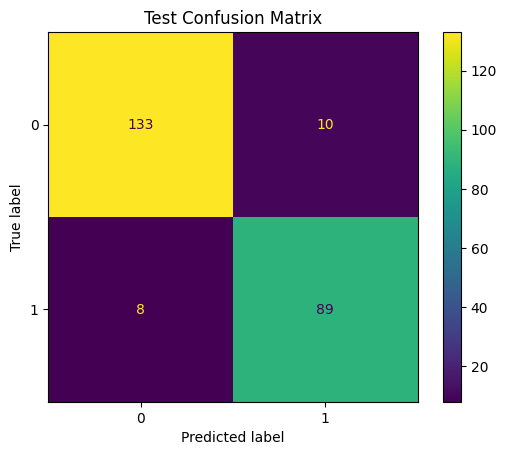

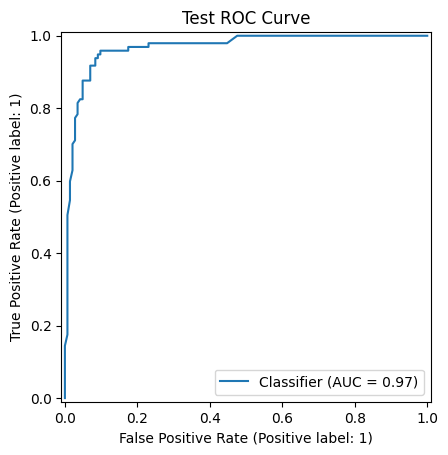

In [ ]:
# Choose by validation AUC
best_model = grid_rf if grid_rf.best_score_ >= grid_lr.best_score_ else grid_lr

# Fit on train+val, then evaluate on test (simple approach)
# This gives the model:More samples+
#.   More robust training+Better generalization
X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = np.concatenate([y_train, y_val])

best_model.best_estimator_.fit(X_trval, y_trval)

# y_proba is now a vector of probabilities that
#.    each sample belongs to class 1.
y_proba = best_model.best_estimator_.predict_proba(X_test)[:, 1]

# Uses a threshold of 0.5 to decide class:
# Probability ≥ 0.5 → class 1/Probability < 0.5 → class 0
# y_pred is now a vector of predicted class labels.
y_pred = (y_proba >= 0.5).astype(int)

# roc_auc_score → calculates the Area Under the ROC Curve.
# Measures how well the model ranks positive vs negative samples.
# AUC ranges from 0.5 (random) to 1.0 (perfect).
auc = roc_auc_score(y_test, y_proba)

# Shows the count of true/false positives and negatives:
cm = confusion_matrix(y_test, y_pred)

print("Test ROC-AUC:", round(auc, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Test Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Test ROC Curve")
plt.show()

### B6. Short Reflection
In 4–6 sentences:  
- Which model performed better and why might that be?  
- Which metric is most appropriate here and why?  
- How would class imbalance change your approach?

*Your reflection:*

## C. Ethics & Deployment (Short Answer)

### C1. Bias & Fairness
**Q:** Describe two ways to detect potential bias in a classification model and one mitigation technique.

*Your answer:*

### C2. Minimal Deployment Thought Exercise
**Q:** You need to deploy the chosen model as a REST endpoint. List the minimal components (data validation, versioning, monitoring) you would include to ensure reliability.

*Your answer:*

## ✅ Final Checklist
- [ ] All cells run without error
- [ ] All requested plots produced
- [ ] Reflections written
- [ ] Decisions supported by metrics